## 搭建pytorch神经网络进行气温预测


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

%matplotlib inline 是一个在 Jupyter Notebook 或者 JupyterLab 中使用的魔术命令，用于将 matplotlib 的图形直接嵌入到当前的单元格中。

当你使用 %matplotlib inline 或 %matplotlib notebook 命令时，Jupyter Notebook 会自动将 matplotlib 的图形嵌入到单元格中，而不是在新窗口中打开它们。这可以避免在运行代码时频繁切换窗口的麻烦，使代码和图形在同一地方呈现，便于比较和调试。

注意：使用 %matplotlib inline 命令可能会导致图形显示不完整或者过于拥挤，因此需要根据具体情况调整图形大小和位置。

In [2]:
data_path = "./data/temps.csv"
features = pd.read_csv(data_path)

# 看看数据长什么样子
features.head()
# 从生产的角度来看，会有这么干净整齐的数据吗？
# 可能会存在数据缺失，格式不对，异常值录入等情况

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


数据表中
* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

In [3]:

print("数据维度：", features.shape)

数据维度： (348, 9)


In [4]:
# 处理时间数据
import datetime

# 如何获取df的某一列值， 分别得到年，月，日，这里得到的years的数据格式是怎样的？
# <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>
# dataFrame 和 Series有什么区别？

years = features['year']
months = features['month']
days = features['day']
print(type(features), type(years))

# datetime格式
# 这里的zip是什么操作？
# zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
# 不仅仅是思考问题，记录solution，还需要用脑子去记下来
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


### dataFrame 和 Series有什么区别？
series，只是一个一维数据结构，它由index和value组成。 dataframe，是一个二维结构，除了拥有index和value之外，还拥有column。 联系： dataframe由多个series组成，无论是行还是列，单独拆分出来都是一个series。

In [5]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

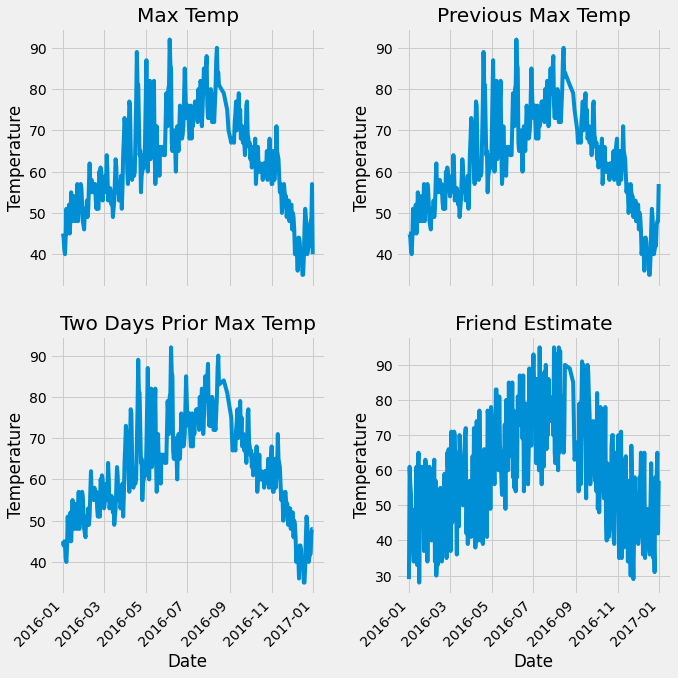

In [6]:
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)  # x轴标签倾斜45°
# fig.autofmt_xdate(rotation=45) 是 Matplotlib 中的一个函数，用于自动格式化日期坐标轴标签并设置其旋转角度。

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)
# plt.tight_layout() 是 Matplotlib 库中的一个函数，用于调整图形的布局，以便更好地展示图形中的元素。
# 它会自动调整子图之间的间距和大小，使它们更加紧凑和美观。

In [7]:
# 独热编码
# 使用 pd.get_dummies() 可以方便地实现分类变量的独热编码（one-hot encoding）。
# 独热编码是一种常用的特征工程方法，用于将分类变量转换为多个二值变量，从而方便在机器学习算法中使用。
# 它这里默认是只会对列中字符串类型进行操作，数值类型的没有变换
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [8]:
# features.head(3)

In [9]:
# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
features= features.drop('actual', axis = 1)

# 名字单独保存一下，以备后患?
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

In [10]:
features.shape

(348, 14)

preprocessing.StandardScaler().fit_transform(features) 是 Scikit-learn 库中的一个预处理步骤，用于对数据进行标准化处理。

具体来说，preprocessing.StandardScaler() 是一个标准化处理类，用于将数据转换为均值为 0、标准差为 1 的标准正态分布。该类实现了 fit_transform() 方法，可以在训练集上拟合模型并转换数据。

In [11]:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)


In [12]:
# 打印出来可以看到，独热编码对应的那些列，也进行了归一化，为什么这个也需要进行归一化，对原始数据会不会有什么影响？
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

### 构建网络模型

In [13]:
x = torch.tensor(input_features, dtype = float)

y = torch.tensor(labels, dtype = float)

# 权重参数初始化
# torch.randn是PyTorch中的一个函数，用于生成一个符合均值为0，方差为1的正态分布（标准正态分布）中填充随机数的张量。
weights = torch.randn((14, 128), dtype = float, requires_grad = True) 
biases = torch.randn(128, dtype = float, requires_grad = True) 
weights2 = torch.randn((128, 1), dtype = float, requires_grad = True) 
biases2 = torch.randn(1, dtype = float, requires_grad = True)


learning_rate = 0.001 
losses = []

for i in range(1000):
    # 计算隐层, 进行矩阵乘法
    # result = torch.mm(x, weights)
    # hidden = result + biases
    hidden = x.mm(weights) + biases
    # 加入激活函数
    hidden = torch.relu(hidden)
    # 预测结果
    predictions = hidden.mm(weights2) + biases2
    # 计算损失
    loss = torch.mean((predictions - y) ** 2)
    # 后续需要画图，所以需要转换格式
    losses.append(loss.data.numpy())
    
    # 打印损失值
    if i % 100 == 0:
        print('loss:', loss)
    #返向传播计算
    loss.backward()
    
    # 更新参数
    # 负号--梯度的反方向，也就是函数值下降的方向
    # 很好奇，这些这么原始的代码是从哪里来的，这些方法好像也点不进去
    weights.data.add_(- learning_rate * weights.grad.data)  
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)
    
    # 每次迭代都得记得清空
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()



loss: tensor(3419.7858, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(150.6498, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(145.2710, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.6142, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.7065, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.1206, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.6889, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.3470, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.0778, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.8592, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [14]:
predictions.shape

torch.Size([348, 1])

### 更简单的构建网络模型

In [16]:
input_size = input_features.shape[1]  # 特征数
hidden_size = 128
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss(reduction='mean')
# 优化器，Adam相对SGD效率更高
optimizer = torch.optim.Adam(my_nn.parameters(), lr = 0.001)

In [17]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # 每一个epoch，都会把所有的数据进行一个全部的遍历，遍历的方式是一个batch一个batch进行计算
    # MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        # 取了一个batch的数据
        xx = torch.tensor(input_features[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(labels[start:end], dtype = torch.float, requires_grad = True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        # 先做梯度的清零
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # 参数更新
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    # 打印损失
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 3935.2478
100 37.559986
200 35.617893
300 35.269913
400 35.100517
500 34.9661
600 34.845573
700 34.72819
800 34.61022
900 34.48901


预测训练结果

In [20]:
x = torch.tensor(input_features, dtype = torch.float)
predict = my_nn(x).data.numpy()

In [21]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)}) 

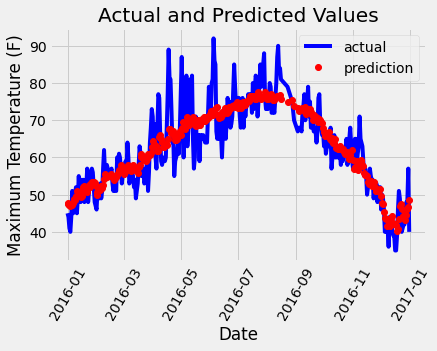

In [22]:
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60')
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');
